# Dota 2: по первым 5 минутам игры предсказать победителя

In [36]:
import pandas as pd 
features = pd.read_csv('./features.csv', index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

## Этап 1: градиентный бустинг

### 1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках?

Удаляем **duration, tower_status_radiant, tower_status_dire, barracks_status_radiant, barracks_status_dire** так как они помечены в описании данных как отсутствующие в тестовой выборке, а **radiant_win** выделяем в целевую переменную

In [37]:
X = features.iloc[:, :-6]
y = features.iloc[:, -5] # radiant_win

X.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,0.725331,39.508650,62.442018,15.261950,34.137158,1.907288,1.155609,0.813459,0.710122,40.701397
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-236.000000,-45.000000,-90.000000,180.000000,0.000000,0.000000,0.000000,0.000000,-84.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,0.000000,-31.000000,83.000000,-86.000000,185.000000,2.000000,3.000000,2.000000,0.000000,-31.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,1.000000,-15.000000,131.000000,-84.000000,203.000000,3.000000,3.000000,2.000000,1.000000,-16.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,1.000000,9.000000,165.000000,-79.000000,238.000000,4.000000,4.000000,3.000000,1.000000,8.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,25.000000,300.000000,300.000000,296.000000,300.000000,21.000000,9.000000,9.000000,13.000000,300.000000


Так как для большинства признаков имеются **97230 значений**, выведем все признаки у которых значений меньше. Это и будут признаки с пропусками:

In [38]:
for field, value in X.count().iteritems():
    if (value != 97230):
        print(field, value)

first_blood_time 77677
first_blood_team 77677
first_blood_player1 77677
first_blood_player2 53243
radiant_bottle_time 81539
radiant_courier_time 96538
radiant_flying_courier_time 69751
radiant_first_ward_time 95394
dire_bottle_time 81087
dire_courier_time 96554
dire_flying_courier_time 71132
dire_first_ward_time 95404


#### Объяснение пропусков в данных

Такое событие как "первая кровь" просто могло "не успеть" произойти за первые 5 минут. Соответсвенно все связанные с этим событием признаки (**first_blood_time, first_blood_team, first_blood_player1, first_blood_player2**) могут быть пропущены.

Признаки **bottle_time, courier_time, flying_courier_time** (для обоих команд) – это временные отметки первых приобретений командами разных предметов – они, так же, могли не произойти в первые 5 минут.

**first_ward_time** – время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля – это событие так же могло не произойти в первые 5 минут.

### 2. Как называется столбец, содержащий целевую переменную?

In [10]:
features.radiant_win

match_id
0         1
1         1
2         0
3         0
4         0
         ..
114402    0
114403    1
114404    0
114405    0
114406    1
Name: radiant_win, Length: 97230, dtype: int64

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? 

Сперва нужно заполнить пропуски в данных. Замена пропусков на нули с помощью функции fillna() является предпочтительным для логистической регрессии, поскольку это позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев же часто лучшим вариантом оказывается замена пропуска **на очень большое или очень маленькое значение** — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска **на среднее значение признака**.

**Время кросс-валидации и качество модели** для градиентного бустинга для разных вариантов заполнения пропусков:

n_estimators | zeros | mean | max | "smart" | time
:-|:-|:-:|:-:|:-:|:-:
**10**| 0.6649558681563331| 0.6635333194156015 | 0.6647780915249151 | **0.6672066401102352** | 33.445419
**20**| 0.6814950788414773| 0.6829242149793624 | 0.6834380810939771 | **0.6840134232351188** | 1:07.740243
**30**| 0.689191650297613 | 0.6890508403322704 | **0.6904314881653921** | 0.6903342322631149 | 1:36.066576
**40**| 0.6937108190451439 |  |  |  | 2:13.122062
**50**| 0.6974049246815414 |  |  |  | 2:49.254025
**100**| 0.7060767478561737 |  | **0.7064713320156679** | 0.7060297461364655 | 5:34.729552

- `zeros`: пропуски заменены на нули
- `mean`: пропуски заменены на среднее по колонке
- `max`: пропуски заменены на большое значение (100**10)
- `smart`: временный признаки заменил на **среднее**, а идентификаторы игроков (напрмер поле first_blood_player1) – на **max**

In [39]:
# Код замены значений "smart"

X['first_blood_time'].fillna((X['first_blood_time'].mean()), inplace=True)
X['first_blood_team'].fillna(100**10, inplace=True)
X['first_blood_player1'].fillna(100**10, inplace=True)
X['first_blood_player2'].fillna(100**10, inplace=True)

X['radiant_bottle_time'].fillna((X['radiant_bottle_time'].mean()), inplace=True)
X['radiant_courier_time'].fillna((X['radiant_courier_time'].mean()), inplace=True)
X['radiant_flying_courier_time'].fillna((X['radiant_flying_courier_time'].mean()), inplace=True)
X['radiant_first_ward_time'].fillna((X['radiant_first_ward_time'].mean()), inplace=True)

X['dire_bottle_time'].fillna((X['dire_bottle_time'].mean()), inplace=True)
X['dire_courier_time'].fillna((X['dire_courier_time'].mean()), inplace=True)
X['dire_flying_courier_time'].fillna((X['dire_flying_courier_time'].mean()), inplace=True)
X['dire_first_ward_time'].fillna((X['dire_first_ward_time'].mean()), inplace=True)

In [44]:
# Код запуска градиентного бустинга с кросс-валидацией**
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np
import time
import datetime

def run_model(n_estimators):
    start_time = datetime.datetime.now()

    cv = KFold(n_splits=5, shuffle=True)
    clf = GradientBoostingClassifier(n_estimators=n_estimators)

    score = cross_val_score(estimator=clf, X=X, y=y, cv=cv, scoring='roc_auc').mean()
    
    print('n:', n_estimators)
    print('score:', score)
    
    print('time:', datetime.datetime.now() - start_time)
    return score

n: 10
score: 0.6688548663371444
time: 0:00:36.619918
n: 20
score: 0.6835058403153875
time: 0:01:14.177654
n: 30
score: 0.6898086087784725
time: 0:01:44.202701
n: 40
score: 0.694332922599396
time: 0:02:23.505394
n: 50
score: 0.6975804130511164
time: 0:02:58.015014
n: 100
score: 0.7066900147460583
time: 0:05:42.553348


<AxesSubplot:>

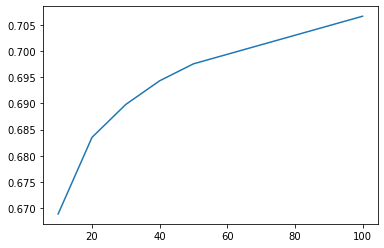

In [45]:
scores = {}

for n_estimators in [10, 20, 30, 40, 50, 100]:
    score = run_model(n_estimators)
    scores[n_estimators] = score

scores = pd.Series(scores)
scores.plot()

### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

`Судя по результатам в табличке, чем больше деревьев, тем выше качество. Так что да, если каждый процент качества важен – имеет смысл использовать больше деревьев. Чтобы ускорить обучение, можно уменьшить глубину деревьев в градиентом бустинге (max_depth).`

## Этап 2: логистическая регрессия

### 1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

 ---- | gradient boosting (100 trees) | logistic regression 
:-|:-|:-
**time** | 5:34.729552 | **2.544677**
**accuracy** | 0.7064 | **0.7164**

`И время и accuracy лучше чем для бустинга со 100 деревьями.`

**Код**
```
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

features = pandas.read_csv('./features.csv', index_col='match_id')

X = features.iloc[:, :-6]
y = features.iloc[:, -5] # radiant_win column

X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

start_time = datetime.datetime.now()

cv = KFold(n_splits=5, shuffle=True)
clf = LogisticRegression(penalty='l2', C=0.01)

accuracies = cross_val_score(estimator=clf, X=X_scaled, y=y, cv=cv, scoring='roc_auc')

print('accuracy:', np.mean(accuracies))
print('time:', datetime.datetime.now() - start_time)  
```

**Bonus** <br/>
Use pipe in order to prevent most risks of data leaking during scaling. But there were no effect ... 
```

pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=0.1))
cv = KFold(n_splits=5, shuffle=True)
accuracies = cross_val_score(pipe, X_scaled, y, cv=cv)

print('accuracy:', np.mean(accuracies))
```


### 2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

`И время и accuracy остались почти теми же, может быть это говорит о том, что категориальные признаки в таком виде, каком они сейчас находятся в данных, никак не влияют на модель`

**Код**
```
categorial_columns = ['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']

categorial_features = X[categorial_columns]

X.drop(columns=categorial_columns, inplace=True)
```

### 3. Сколько различных идентификаторов героев существует в данной игре?

`108 различных значений, но максимальное значение – 112, поэтому нужно 112 бинарных признаков для формирования "мешка слов"`


**Код**
```
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
unique_heroes = np.unique(X_train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в train: {len(unique_heroes)}. Максимальный ID героя: {N}.")

#Число уникальных героев в train: 108. Максимальный ID героя: 112.

heroes = categorial_features.drop(columns=['lobby_type'])

X_pick = np.zeros((heros.shape[0], 112))

for i, match_id in enumerate(heroes.index):
    for p in range(5):
        X_pick[i, heroes.loc[match_id]['r%d_hero' % (p+1)]-1] = 1
        X_pick[i, heroes.loc[match_id]['d%d_hero' % (p+1)]-1] = -1

```



### 4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

### 5. Какое минимальное и максимальное значение прогноза на тренировочной выборке получилось у лучшего из алгоритмов?

`Точность увеличилась с 0.7164 до 0.7544 – это доказывает тот факт, что информация о выбранных героях важна.`

`Минимальная точность у бустинга с 10 деревьями, максимальная – у логистической регрессии с бинарными признаками для категориальных фич`

 ---- | gradient boosting (10 trees) | random forest | gradient boosting (100 trees) | logistic regression | logistic regression w/ bag of words
:-|:-|:-|:-|:-|:-
**time** | 33.445419 | 51.348811 | 5:34.729552 | 2.544677 | **3.67545**
**accuracy** | 0.6649 | 0.698 | 0.7064 | 0.7164 | **0.7544**

## Финальная модель

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import time
import datetime

In [11]:
X_train = pd.read_csv('./features.csv', index_col='match_id')
y_train = X_train.iloc[:, -5] # radiant_win column
X_train = X_train.iloc[:, :-6] # get rid off last features since they aren't presented in the 'test' dataset

X_test = pd.read_csv('./features_test.csv', index_col='match_id')

X_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [12]:
# fill NA, transform categorial features to 'bag of words' and etc
X_train_prepared = prepare_data(X_train) 
X_test_prepared = prepare_data(X_test)

In [13]:
# fit model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_prepared)

clf = LogisticRegression(penalty='l2', C=0.01)
clf.fit(X_train_scaled, y_train)

y_train_score = clf.predict_proba(X_train_scaled)[:, 1]
roc_auc_score(y_train, y_train_score)

0.7544608380985481

In [14]:
# make predictions on 'test' dataset
X_test_scaled = scaler.transform(X_test_prepared)
y_test_score = clf.predict_proba(X_test_scaled)[:, 1]
y_test_score

array([0.8227909 , 0.75216683, 0.18906701, ..., 0.2379355 , 0.6283895 ,
       0.42762756])

In [18]:
predictions = pd.DataFrame(
    data=clf.predict_proba(X_test_scaled),
    index=X_test['match_id'],
    columns=clf.classes_
)

predictions.head()

,0,1
match_id,,
6,0.177209,0.822791
7,0.247833,0.752167
10,0.810933,0.189067
13,0.142361,0.857639
16,0.756036,0.243964


In [25]:
# Check predictions range - should be in range[0, 1]
print(f"""Min value: {np.min(predictions[1]):.3f} \nMax value: {np.max(predictions[1]):.3f}\n""")

# Check predictions variance - shoudn't be constant
print(predictions[1].var())

Min value: 0.009 
Max value: 0.996

0.048501035248763674


In [33]:
# make csv file with predictions
answer = pd.concat([X_test['match_id'], pd.DataFrame(y_test_score)], axis=1)

compression_opts = dict(method='zip', archive_name='out.csv')  
answer.to_csv('out.zip', index=False, compression=compression_opts)  

In [10]:
def prepare_data(X):
    # fill in NA with zeros
    X.fillna(0, inplace=True)

    # extract categorial features
    categorial_columns = ['lobby_type',
                          'r1_hero','r2_hero','r3_hero','r4_hero','r5_hero',
                          'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero']
    categorial_features = X[categorial_columns]
    X.drop(columns=categorial_columns, inplace=True)

    # drop lobby type since ... I think itsn't important for analysis
    heroes = categorial_features.drop(columns=['lobby_type'])

    # 'heroes' are categorial features with 112 unique values
    # let's transfrom them into 'bag of words'
    X_pick = np.zeros((heroes.shape[0], 112))
    for i, match_id in enumerate(heroes.index):
        for p in range(5):
            X_pick[i, heroes.loc[match_id]['r%d_hero' % (p+1)]-1] = 1
            X_pick[i, heroes.loc[match_id]['d%d_hero' % (p+1)]-1] = -1

    # concat back X and 'heroes'
    X.reset_index(level=0, inplace=True)
    X_full = pd.concat([X, pd.DataFrame(X_pick)], axis=1)
    X_full.set_index('match_id', inplace=True)
    
    return X_full

### Другие решения

**Random Forest, best score: ~ 0.698**

```
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100,
                               bootstrap=True, oob_score=True, n_jobs=2,
                               random_state=42)

    start_time = datetime.datetime.now()

    # Defining 3-dimensional hyperparameter space as a Python dictionary
    hyperparameter_space = {'max_depth':[None,4,6,8,10,12,15,20], 
                            'min_samples_leaf':[1,2,4,6,8,10,20,30],
                            'max_features':['auto','sqrt','log2']}

    from sklearn.model_selection import GridSearchCV
    gs = GridSearchCV(rf, param_grid=hyperparameter_space , 
                      scoring='roc_auc',
                      n_jobs=2, cv=5, return_train_score=True)

    gs.fit(X_train_prepared, y_train)
    print("Optimal hyperparameter combination: ", gs.best_params_)
    print("ROC-AUC score of the best_estimator: ", gs.best_score_)

    gs.best_estimator_.fit(X_train_prepared, y_train)
    y_pred = gs.best_estimator_.predict_proba(X_test_prepared)[:,1]


    print('time:', datetime.datetime.now() - start_time) 

    # Optimal hyperparameter combination:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 30}
    # ROC-AUC score of the best_estimator:  0.6984936500672665
    # time: 0:35:51.348811

    # forrest_out = gs.best_estimator_.predict_proba(X_test_prepared)[:,1]
```

**Код выбора коэф-та регуляризации**
```
grid = {'C': np.power(10.0, np.arange(-5, 6))}
gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=cv)
gs.fit(X_scaled, y)
gs.best_estimator_, gs.best_score_, gs.best_params_
```

**Custom realization of cross validation**

```
def custom_cross_val(model, kf, X, y):
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index.tolist()], X[test_index.tolist()]
        y_train, y_test = y.values[train_index], y.values[test_index]

        model.fit(X_train, y_train)

        y_score = model.predict_proba(X_test)[:, 1]
        accuracies.append(roc_auc_score(y_test, y_score))

    return accuracies
```